In [1]:
%load_ext load_style
%load_style talk.css

# Standardized Precipitation Index (SPI)

This notebook is inspired by the [NCL SPI example](https://www.ncl.ucar.edu/Applications/spi.shtml).

The Standardized Precipitation Index (SPI) is a probability index that gives a better representation of abnormal wetness and dryness than the Palmer Severe Drought Index (PSDI). The World Meteorological Organization (WMO) recommends, that all national meteorological and hydrological services should use the SPI for monitoring of dry spells. Some advantages of the SPI:
* It requires only monthly precipitation.
* It can be compared across regions with markedly different climates.
* The standardization of the SPI allows the index to determine the rarity of a current drought.
* It can be created for differing periods of 1-to-36 months.

A shortcoming of the SPI, as noted by Trenbert et al (2014):

* "the SPI are based on precipitation alone and provide a measure only for water supply. They are very useful as a measure of precipitation deficits or meteorological drought but are limited because they do not deal with the ET [evapotranspiration] side of the issue."

In this notebook, SPI is obtained by fitting a gamma distribution to monthly GPCP precipitation data from 1979 to 2010. The data can be downloaded from https://www.ncl.ucar.edu/Applications/Data/.

## 1. Import basic libraries

In [2]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections

import datetime             
from netCDF4 import Dataset # http://unidata.github.io/netcdf4-python/
from netCDF4 import netcdftime
from netcdftime import utime
from dim_spi_n import *  # private lib

from timeit import default_timer as timer

import warnings
warnings.simplefilter('ignore')

## 2. Read monthly precipitation data

### 2.1 Read data

In [3]:
infile = r'data/V22_GPCP.1979-2010.nc'
fh     = Dataset(infile, mode='r') # file handle, open in read only mode
fh.set_auto_mask(False)
lons   = fh.variables['lon'][:]
lats   = fh.variables['lat'][:]
nctime = fh.variables['time'][:]
t_unit = fh.variables['time'].units
pr     = fh.variables['PREC'][:]

try :
    t_cal = fh.variables['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

fh.close() # close the file

undef = -99999.0
pr[pr==undef] = np.nan
pr = pr.astype(np.float64)

nt,nlat,nlon = pr.shape
ngrd = nlat*nlon

### 2.2 Parse times

In [4]:
utime   = netcdftime.utime(t_unit, calendar = t_cal)
datevar = utime.num2date(nctime)

datevar[0:5]

array([datetime.datetime(1979, 1, 16, 0, 0),
       datetime.datetime(1979, 2, 14, 0, 0),
       datetime.datetime(1979, 3, 16, 0, 0),
       datetime.datetime(1979, 4, 15, 0, 0),
       datetime.datetime(1979, 5, 16, 0, 0)], dtype=object)

## 3. Calculate SPI

In [5]:
pr_grd  = pr.reshape((nt,ngrd), order='F')
spi_grd = np.zeros(pr_grd.shape)
spi_grd[:,:] = np.nan
nrun = 24

s = timer()
for igrd in np.arange(ngrd):
    one_pr = pr_grd[:,igrd]
               
    if (isinstance(one_pr, np.ma.MaskedArray)) and one_pr.mask.all():
        print(igrd)
        continue                    
    else:  
        spi_grd[:,igrd] = dim_spi_n(one_pr, nrun)       
        
spi = spi_grd.reshape((nt,nlat,nlon), order='F')

e = timer()
print(e - s)

147.248856721


## 4. Visualize

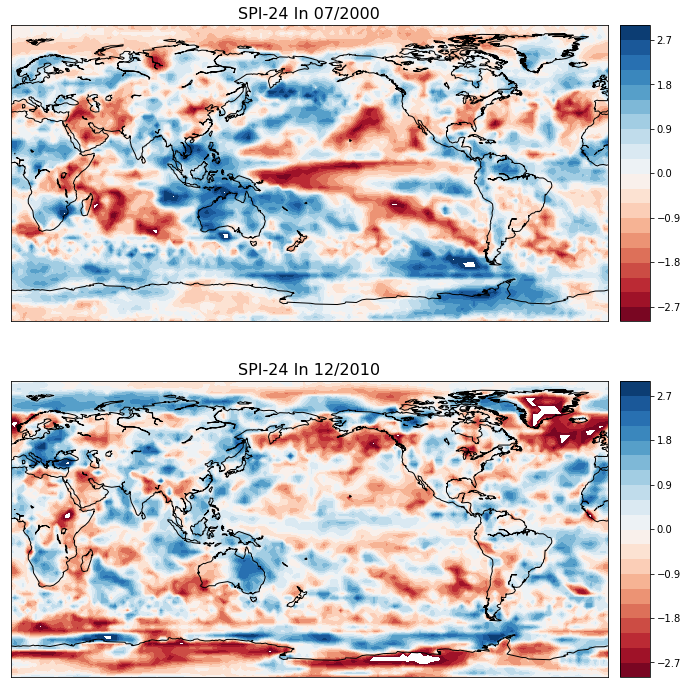

In [6]:
m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats),
        urcrnrlon=max(lons), urcrnrlat=max(lats))

x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-3.0, 3.0, 21)

fig = plt.figure(figsize=(15,12))

# Plot the first one
ax = fig.add_subplot(211)
idx = 258
cs = m.contourf(x, y,spi[idx,:,:], clevs, cmap=plt.cm.RdBu)
m.drawcoastlines()
cb = m.colorbar(cs)
plt.title('SPI-' + str(nrun) + ' In '+ datetime.date.strftime(datevar[idx], "%m/%Y"), fontsize=16)

#  plot the second one
ax = fig.add_subplot(212)
idx = -1
cs = m.contourf(x, y,spi[idx,:,:], clevs, cmap=plt.cm.RdBu)
m.drawcoastlines()
cb = m.colorbar(cs)
plt.title('SPI-' + str(nrun) + ' In '+ datetime.date.strftime(datevar[idx], "%m/%Y"), fontsize=16)

## References

McKee, T.B., N.J. Doesken, and J. Kleist, 1993. 
The relationship of drought frequency and duration ot time scales. 
Eighth Conference on Applied Climatology, American Meteorological Society 
Jan 17-23, 1993, Anaheim CA, pp. 179-186.

McKee, T.B., N.J. Doesken, and J. Kleist, 1995. 
Drought monitoring with multiple time scales. 
Ninth Conference on Applied Climatology, American Meteorological Society 
Jan 15-20, 1995, Dallas TX, pp. 233-236.

Guttman, N.B., 1998. 
Comparing the Palmer Drought Index and the Standardized Precipitation Index. 
Journal of the American Water Resources Association, 34(1), 113-121.

Guttman, N.B., 1999. Accepting the Standardized Precipitation Index: A calculation algorithm. 
Journal of the American Water Resources Association, 35(2), 311-322.

Trenberth et al (2014)
Global warming and changes in drought
Nature Climate Change 4, 17-22;   doi:10.1038/nclimate2067